In [1]:
import numpy as np
import argparse
import sys
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import  ActivityRegularization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.python.client import device_lib
from tensorflow.keras import utils as np_utils

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
#print(device_lib.list_local_devices())
if tf.test.gpu_device_name():
    print('Default GPU Device:  {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

gpus = tf.config.experimental.list_physical_devices('GPU') 
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
# Settings -----------

SOURCE_IMG_WIDTH = 380
SOURCE_IMG_HEIGHT = SOURCE_IMG_WIDTH

DATA_PATH = 'Data' +str(SOURCE_IMG_WIDTH)+ '\\'
# Settings -----------

# Fix the random seed for reproducibility
seed = 7
np.random.seed(seed)

Default GPU Device:  /device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Data Generators

# Data augmentation should only apply to the training set (If any)
train_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="nearest",
                                   brightness_range=(0.6,1.4))

valid_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="nearest")

test_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="nearest",
                                   brightness_range=(0.6,1.4))


train_generator = train_datagen.flow_from_directory(
    directory=DATA_PATH + 'train\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb", #rgb
    batch_size=8,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
valid_generator = valid_datagen.flow_from_directory(
    directory=DATA_PATH + 'val\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=DATA_PATH + 'test\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    #save_to_dir="preview\\",
    #save_prefix ="TEST_",
    #save_format="tif",
    seed=42
)

np.save('labels', train_generator.class_indices)

Found 6890 images belonging to 33 classes.
Found 3445 images belonging to 33 classes.
Found 3445 images belonging to 33 classes.


In [4]:
# Model defination
base_model = EfficientNetB4(include_top=False, input_shape=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH, 3), weights='imagenet')

# Turn off the tainability of the base model
for layer in base_model.layers:
    layer.trainable = False
'''
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(ActivityRegularization(l2=0.01, l1=0.01))
model.add(Dense(33, activation='softmax', name='outputLayer'))
'''
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
#model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(.5))
model.add(ActivityRegularization(l2=0.01, l1=0.01))
model.add(Dense(33, activation='softmax', name='outputLayer'))

model.summary()


'''
for ly in base_model.layers:
    print(ly.name, ly.trainable)
'''

# Compile the model
model.compile(loss='categorical_crossentropy',
              #optimizer=optimizers.SGD(),
              optimizer=optimizers.Adam(lr=1e-2),
              #optimizer=optimizers.RMSprop(lr=1e-3),
              #optimizer=optimizers.Adadelta(lr=1),
              #optimizer=optimizers.Nadam(lr=2e-4),              
              #optimizer=optimizers.Adamax(lr=2e-4),              
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 12, 12, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
activity_regularization (Act (None, 1792)              0         
_________________________________________________________________
outputLayer (Dense)          (None, 33)                59169     
Total params: 17,732,992
Trainable params: 59,169
Non-trainable params: 17,673,823
_______________________________________

In [5]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc_top = ModelCheckpoint('eff_best_top_checkpoint.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=False)
mc = ModelCheckpoint('eff_best_checkpoint.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=False)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

In [6]:
# train the top 

EPOCHS = 20

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("Start Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

history_pre = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks=[tensorboard_callback, es, mc_top, lr]
)

print("End Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

Start Training Time:  17:33:39
Epoch 1/20
430/430 [==============================] - ETA: 0s - loss: 7.3344 - accuracy: 0.6765
Epoch 00001: val_accuracy improved from -inf to 0.55058, saving model to eff_best_top_checkpoint.h5
430/430 [==============================] - 96s 223ms/step - loss: 7.3344 - accuracy: 0.6765 - val_loss: 6.6600 - val_accuracy: 0.5506
Epoch 2/20
430/430 [==============================] - ETA: 0s - loss: 7.1161 - accuracy: 0.7651
Epoch 00002: val_accuracy did not improve from 0.55058
430/430 [==============================] - 87s 203ms/step - loss: 7.1161 - accuracy: 0.7651 - val_loss: 7.5979 - val_accuracy: 0.5453
Epoch 3/20
430/430 [==============================] - ETA: 0s - loss: 7.1131 - accuracy: 0.7809
Epoch 00003: val_accuracy improved from 0.55058 to 0.66512, saving model to eff_best_top_checkpoint.h5
430/430 [==============================] - 88s 205ms/step - loss: 7.1131 - accuracy: 0.7809 - val_loss: 6.3043 - val_accuracy: 0.6651
Epoch 4/20
430/430 [=

In [7]:
model.load_weights("eff_best_top_checkpoint.h5")

'''
# accuracy 94%
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
'''
        
'''
# accuracy 95%
for layer in base_model.layers[-31:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True
'''    

'''
#94.83%
for layer in base_model.layers[-31:]:    
        layer.trainable = True
        
   '''     
#98%
base_model.trainable = True
'''
for layer in model.layers:
    if(layer.name=="efficientnetb3"):
        for ly in layer.layers:
            print(ly.name, ly.trainable)
    print(layer.name, layer.trainable)
'''
    
# Compile the model
model.compile(loss='categorical_crossentropy',
              #optimizer=optimizers.SGD(),
              optimizer=optimizers.Adam(lr=1e-4),
              #optimizer=optimizers.RMSprop(lr=1e-3),
              #optimizer=optimizers.Adadelta(lr=1),
              #optimizer=optimizers.Nadam(lr=2e-4),              
              #optimizer=optimizers.Adamax(lr=2e-4),              
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 12, 12, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
activity_regularization (Act (None, 1792)              0         
_________________________________________________________________
outputLayer (Dense)          (None, 33)                59169     
Total params: 17,732,992
Trainable params: 17,607,785
Non-trainable params: 125,207
______________________________________

In [10]:
EPOCHS = 200

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("Start Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

history_pre = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks=[tensorboard_callback, es, mc, lr]
)

print("End Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

Start Training Time:  18:58:52
Epoch 1/200
861/861 [==============================] - ETA: 0s - loss: 3.6021 - accuracy: 0.6053
Epoch 00001: val_accuracy improved from -inf to 0.83198, saving model to eff_best_checkpoint.h5
861/861 [==============================] - 417s 484ms/step - loss: 3.6021 - accuracy: 0.6053 - val_loss: 1.3480 - val_accuracy: 0.8320
Epoch 2/200
861/861 [==============================] - ETA: 0s - loss: 1.2953 - accuracy: 0.8015
Epoch 00002: val_accuracy improved from 0.83198 to 0.90988, saving model to eff_best_checkpoint.h5
861/861 [==============================] - 421s 488ms/step - loss: 1.2953 - accuracy: 0.8015 - val_loss: 0.8580 - val_accuracy: 0.9099
Epoch 3/200
861/861 [==============================] - ETA: 0s - loss: 0.9479 - accuracy: 0.8657
Epoch 00003: val_accuracy improved from 0.90988 to 0.92994, saving model to eff_best_checkpoint.h5
861/861 [==============================] - 408s 473ms/step - loss: 0.9479 - accuracy: 0.8657 - val_loss: 0.7075 - 

861/861 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9961
Epoch 00028: val_accuracy did not improve from 0.97355
861/861 [==============================] - 387s 449ms/step - loss: 0.1724 - accuracy: 0.9961 - val_loss: 0.3307 - val_accuracy: 0.9541
Epoch 29/200
861/861 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9971
Epoch 00029: val_accuracy did not improve from 0.97355

Epoch 00029: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
861/861 [==============================] - 386s 448ms/step - loss: 0.1620 - accuracy: 0.9971 - val_loss: 0.3080 - val_accuracy: 0.9549
Epoch 30/200
861/861 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9980
Epoch 00030: val_accuracy did not improve from 0.97355
861/861 [==============================] - 386s 448ms/step - loss: 0.1502 - accuracy: 0.9980 - val_loss: 0.2652 - val_accuracy: 0.9573
Epoch 31/200
861/861 [==============================] - ETA: 0s - lo

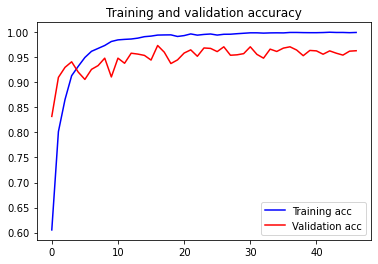

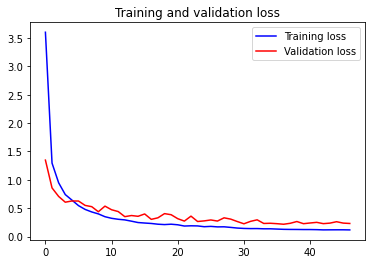

In [11]:
# Plot the accuracy and loss curves
acc = history_pre.history['accuracy']
val_acc = history_pre.history['val_accuracy']
loss = history_pre.history['loss']
val_loss = history_pre.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
model = models.load_model('eff_best_checkpoint.h5')

if os.path.isfile('labels.npy'):
    class_indices = np.load('labels.npy',allow_pickle=True).item()

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
scores = model.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST) 
print("Test Loss =", scores[0], "Test Accuracy =", scores[1])

Test Loss = 0.3191051483154297 Test Accuracy = 0.9709724187850952


[0]
['Acinetobacter.baumanii']


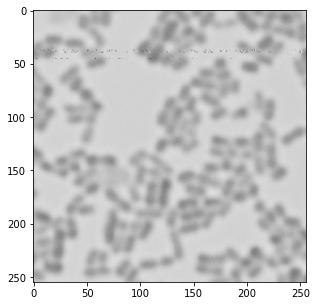

In [13]:
# Manual test
img = image.load_img('data\\test\\Acinetobacter.baumanii\\Acinetobacter.baumanii_0004_30.tif')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(img_tensor[0]/255)
#img_tensor = preprocess_input(img_tensor)
#img_tensor /= 255.

#cls = model.predict(img_tensor)
#print(cls)

cls = model.predict_classes(img_tensor)
print(cls)
label_map = class_indices
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in cls] 
print(predictions) 

[13]
['Lactobacillus.gasseri']


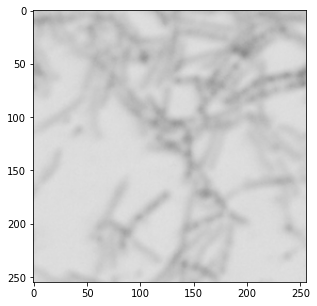

In [14]:
img = image.load_img('data\\test\\Lactobacillus.gasseri\\Lactobacillus.gasseri_0004_11.tif')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(img_tensor[0]/255)
#img_tensor = preprocess_input(img_tensor)
#img_tensor /= 255.

#cls = model.predict(img_tensor)
#print(cls)

cls = model.predict_classes(img_tensor)
print(cls)
label_map = class_indices
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in cls] 
print(predictions) 


Confusion Matrix


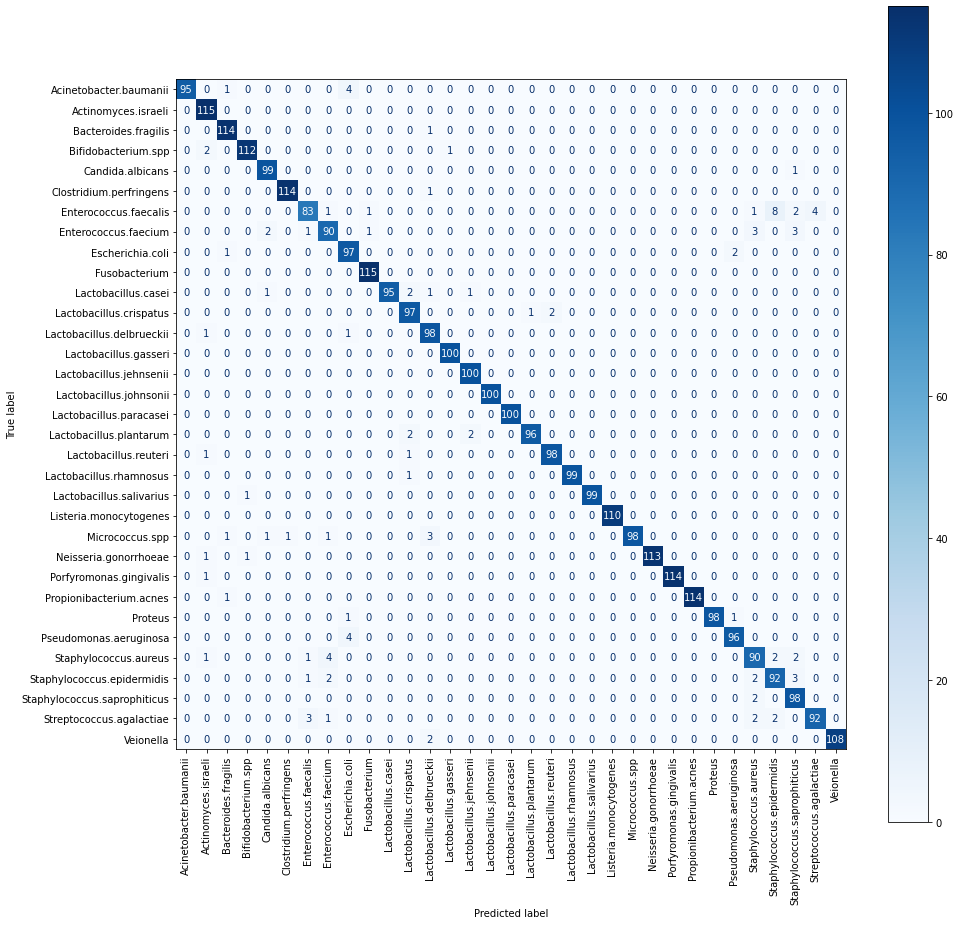

Classification Report
                              precision    recall  f1-score   support

      Acinetobacter.baumanii       1.00      0.95      0.97       100
         Actinomyces.israeli       0.94      1.00      0.97       115
        Bacteroides.fragilis       0.97      0.99      0.98       115
         Bifidobacterium.spp       0.98      0.97      0.98       115
            Candida.albicans       0.96      0.99      0.98       100
     Clostridium.perfringens       0.99      0.99      0.99       115
       Enterococcus.faecalis       0.93      0.83      0.88       100
        Enterococcus.faecium       0.91      0.90      0.90       100
            Escherichia.coli       0.91      0.97      0.94       100
               Fusobacterium       0.98      1.00      0.99       115
         Lactobacillus.casei       1.00      0.95      0.97       100
     Lactobacillus.crispatus       0.94      0.97      0.96       100
   Lactobacillus.delbrueckii       0.92      0.98      0.95       1

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#model = models.load_model('best_checkpoint.h5')
#class_indices = np.load('labels.npy',allow_pickle=True).item()

#np.set_printoptions(threshold=np.inf) # to see the full confusion matrix
np.set_printoptions(threshold=1000) #

#Confusion Matrix and Classification Report

Y_pred = model.predict_generator(test_generator,test_generator.n)
y_pred = np.argmax(Y_pred, axis=1)
target_names = class_indices

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.rcParams["figure.figsize"] = (15,15)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))